BERT for NER using BERTForTokenClassification 

In [1]:
import pandas as pd
annotations = pd.read_csv("./annotations.csv", index_col = ['id'])

In [2]:
annotations

,sentence#,token,tag,relabelled_tags
id,,,,
0,0,Om,CONCEPT,2
1,0,!,O,0
2,1,Having,O,0
3,1,bowed,O,0
4,1,down,O,0
...,...,...,...,...
830510,34331,The,O,0
830511,34331,end,O,0
830512,34331,of,O,0


In [3]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["token"].values.tolist(),
                                                           s["tag"].values.tolist(),
                                                           s["relabelled_tags"].values.tolist())]
        self.grouped = self.data.groupby("sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [4]:
getter = SentenceGetter(annotations)

In [5]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[3]

['Those',
 'ascetics',
 ',',
 'wishing',
 'to',
 'hear',
 'his',
 'wonderful',
 'narrations',
 ',',
 'presently',
 'began',
 'to',
 'address',
 'him',
 'who',
 'had',
 'thus',
 'arrived',
 'at',
 'that',
 'recluse',
 'abode',
 'of',
 'the',
 'inhabitants',
 'of',
 'the',
 'forest',
 'of',
 'Naimisha',
 '.']

In [6]:
def string_labels(l):
    if l == 0:
        return 'O'
    if l == 1:
        return 'Living'
    if l == 2:
        return 'Non-Living'
    return 'q'

In [7]:
labels = [[string_labels(s[2]) for s in sentence] for sentence in getter.sentences]
print(labels[1])

['O', 'O', 'O', 'O', 'Living', 'O', 'Living', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Living', 'O', 'O', 'O', 'O', 'Non-Living', 'O', 'O', 'O']


In [8]:
tag_values = list(set(labels[1]))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [9]:
tag2idx

{'Non-Living': 0, 'O': 1, 'Living': 2, 'PAD': 3}

In [10]:
!pip install huggingface
!pip install sentencepiece

You should consider upgrading via the '/home/shreya15096/.conda/envs/virtualEnv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/shreya15096/.conda/envs/virtualEnv/bin/python -m pip install --upgrade pip' command.


In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AlbertTokenizer, AlbertConfig
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__


'1.9.0+cu102'

In [11]:
MAX_LEN = 75 # try with 512 also which is max
bs = 32

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [13]:
n_gpu

2

In [14]:
device

device(type='cuda')

In [15]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=False)

In [16]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        try:
            # Tokenize the word and count # of subwords the word is broken into
            if pd.isna(word):
                print("found nan")
                word = "null"
            tokenized_word = tokenizer.tokenize(word)
            n_subwords = len(tokenized_word)

            # Add the tokenized word to the final tokenized word list
            tokenized_sentence.extend(tokenized_word)

            # Add the same label to the new list of labels `n_subwords` times
            labels.extend([label] * n_subwords)
        except Exception as e:
            print(word)
            print(label)
            print(e)
            print(sentence)
            print(text_labels)
            print("------")
            return 
    return tokenized_sentence, labels

In [17]:
tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

found nan
found nan


In [18]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [19]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [20]:
input_ids

array([[  13,    1,   79, ...,    0,    0,    0],
       [  13,    1, 5214, ...,    0,    0,    0],
       [  13,    1, 4973, ...,   16,   13,    1],
       ...,
       [  13,    1,  706, ...,    0,    0,    0],
       [  13,    1,  706, ...,    0,    0,    0],
       [  13,    1,  438, ...,    0,    0,    0]])

In [21]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [22]:
tags

array([[0, 0, 0, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [2, 2, 2, ..., 1, 2, 2],
       ...,
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3]])

In [23]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [24]:
train_i, test_i, train_tags, test_tags = train_test_split(input_ids, tags,
                                                            random_state=2021, test_size=0.2)
train_m, test_m, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2021, test_size=0.2)

In [25]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(train_i, train_tags,
                                                            random_state=2021, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(train_m, train_i,
                                             random_state=2021, test_size=0.2)

In [26]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
#test_inputs = torch.tensor(test_i)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
#test_tags = torch.tensor(test_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
#test_masks = torch.tensor(test_m)

In [27]:
tr_inputs

tensor([[   13,     1,    62,  ...,     0,     0,     0],
        [   13,     1, 12597,  ...,  6836,    13,    15],
        [   13,     1,   111,  ...,     0,     0,     0],
        ...,
        [   13,     1, 10717,  ...,     0,     0,     0],
        [   13,     1,    62,  ...,     0,     0,     0],
        [   13,     1,   103,  ...,     0,     0,     0]])

In [28]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

#test_data = TensorDataset(test_inputs, test_masks, test_tags)
#test_sampler = SequentialSampler(test_data)
#test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

In [29]:
import transformers
from transformers import AlbertForTokenClassification, AdamW

transformers.__version__


'4.9.2'

In [30]:
model = AlbertForTokenClassification.from_pretrained(
    "albert-base-v2",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForTokenClassification: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably

In [31]:
model.cuda()

AlbertForTokenClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bi

In [32]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [33]:
from transformers import get_linear_schedule_with_warmup

epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [34]:
from seqeval.metrics import f1_score, accuracy_score


In [35]:
from tqdm import trange
import numpy as np
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    print()


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.055758169618265074
Validation loss: 0.02388354246423385
Validation Accuracy: 0.9918156048435691


/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Living seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Non-Living seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:  10%|█         | 1/10 [01:52<16:54, 112.72s/it]

Validation F1-Score: 0.9409266105561236

Average train loss: 0.01962770107832603
Validation loss: 0.018222563892608335
Validation Accuracy: 0.9944249702647615


Epoch:  20%|██        | 2/10 [03:45<15:00, 112.57s/it]

Validation F1-Score: 0.9589537540376586

Average train loss: 0.011379700299352239
Validation loss: 0.017978049980863647
Validation Accuracy: 0.9943620939895521


Epoch:  30%|███       | 3/10 [05:37<13:07, 112.57s/it]

Validation F1-Score: 0.9598989580044206

Average train loss: 0.006823972353027636
Validation loss: 0.01924745061537684
Validation Accuracy: 0.9957925292505672


Epoch:  40%|████      | 4/10 [07:30<11:15, 112.57s/it]

Validation F1-Score: 0.9701563240170535

Average train loss: 0.004101475872308845
Validation loss: 0.01991142612864361
Validation Accuracy: 0.9947498310200104


Epoch:  50%|█████     | 5/10 [09:22<09:21, 112.35s/it]

Validation F1-Score: 0.9620433338605092

Average train loss: 0.002832599994731139
Validation loss: 0.01981625186454039
Validation Accuracy: 0.9952423618424845


Epoch:  60%|██████    | 6/10 [11:13<07:28, 112.11s/it]

Validation F1-Score: 0.9658544278842364

Average train loss: 0.0016120914207330458
Validation loss: 0.022095907310358598
Validation Accuracy: 0.9956091401145396


Epoch:  70%|███████   | 7/10 [13:05<05:36, 112.08s/it]

Validation F1-Score: 0.9687647893989588

Average train loss: 0.0011531997393735944
Validation loss: 0.02209837365091178
Validation Accuracy: 0.9955043463225238


Epoch:  80%|████████  | 8/10 [14:57<03:43, 112.00s/it]

Validation F1-Score: 0.9683679103888934

Average train loss: 0.0006732996282425897
Validation loss: 0.02418697429885829
Validation Accuracy: 0.995797768940168


Epoch:  90%|█████████ | 9/10 [16:49<01:51, 111.94s/it]

Validation F1-Score: 0.97094125078964

Average train loss: 0.0003720565701455618
Validation loss: 0.025331433252721434
Validation Accuracy: 0.9956615370105475


Epoch: 100%|██████████| 10/10 [18:41<00:00, 112.12s/it]

Validation F1-Score: 0.9696012633241216



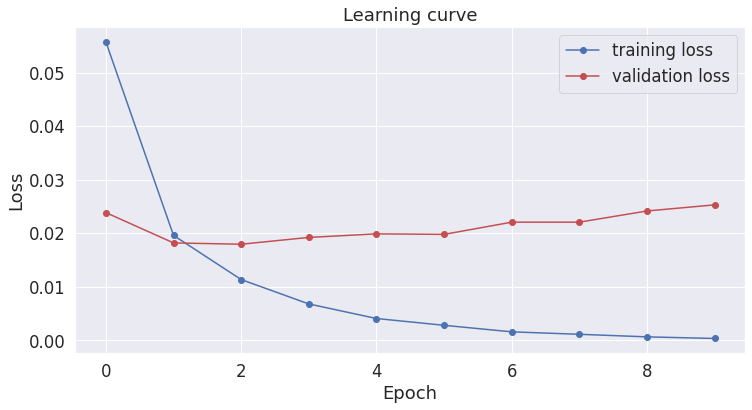

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [37]:
test = torch.tensor(test_i).cuda()

In [38]:
len(test)

6867

In [39]:
label_indices = []
for i in range(0,len(test),bs):
    #batch = [t.to(device) for t in test[i:i+bs]]
    inputs = test[i:i+bs]
        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
    with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
        output = model(inputs)
    label_indice = np.argmax(output[0].to('cpu').numpy(), axis=2)
    label_indices.append(label_indice)

In [41]:
label_indices

[array([[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]]),
 array([[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]]),
 array([[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]]),
 array([[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]]),
 array([[3, 3, 3, ..., 3, 3, 3],
        [1, 1, 1, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
   

In [42]:
label_indices = [elem for twod in label_indices for elem in twod]

In [43]:
np.array(label_indices).shape

(6867, 75)

In [44]:
label_indices

[array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
 

In [ ]:
test.size()

In [45]:
# join bpe split tokens
all_pred_labels = []
all_true_labels = []
all_tokens = []
for i in range(test.size()[0]):
    tokens = tokenizer.convert_ids_to_tokens(test.to('cpu').numpy()[i])
    new_tokens, new_labels, true_labels = [], [], []
    for token, label_idx, true_label_idx in zip(tokens, label_indices[i], test_tags[i]):
        if(token == '[PAD]'):
            continue
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
            true_labels.append(tag_values[true_label_idx])
    all_pred_labels.append(new_labels)
    all_tokens.append(new_tokens)
    all_true_labels.append(true_labels)
#     for token, label, true_label in zip(new_tokens, new_labels, true_labels):
#         print("{}\t{}\t{}".format(label, token, true_label))


In [46]:
from seqeval.metrics import classification_report

In [48]:
print(classification_report(all_pred_labels, all_true_labels))

/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Living seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Non-Living seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

          AD       0.00      0.00      0.00      6260
      Living       0.19      0.79      0.31       267
       iving       0.29      0.90      0.44      2275

   micro avg       0.15      0.26      0.19      8802
   macro avg       0.16      0.56      0.25      8802
weighted avg       0.08      0.26      0.12      8802



In [49]:
i = 657
for token, pred, true in zip(all_tokens[i], all_pred_labels[i], all_true_labels[i]):
    print(token, pred, true)

▁ PAD O
" PAD O
▁ PAD Living
<unk> PAD Living
sh PAD Living
taka PAD Living
▁en PAD O
qui PAD O
red PAD O
▁what PAD O
▁is PAD O
▁meant PAD O
▁by PAD O
▁ PAD Living
<unk> PAD Living
uni PAD Living
▁ PAD O
. PAD O
▁ PAD O
' PAD O
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD
<pad> PAD PAD


In [50]:
len(all_tokens)

6867

In [51]:
test_sentence = '''Ganga dipped her feet in the holy Ganga. Then she took a train to Delhi.'''

In [52]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


O	[CLS]
Non-Living	▁
Living	<unk>
Non-Living	anga
O	▁dipped
O	▁her
O	▁feet
O	▁in
O	▁the
O	▁holy
Non-Living	▁
Non-Living	<unk>
Non-Living	anga
O	.
O	▁
O	<unk>
O	hen
O	▁she
O	▁took
O	▁a
O	▁train
O	▁to
Non-Living	▁
Non-Living	<unk>
Non-Living	el
Non-Living	hi
O	.
Living	[SEP]
